<center><h1><font color='orange'>Generating Synthetic Faces Using Generative Adversarial Networks</font></h1></center>
<center><h3>By: Adam Lieberman</h3></center>
<br>
<br>
<h4>Introduction:</h4>
<p>Generative Adversarial Networks (GANs) can be used to generate synthetic input data. Here, two neural networks compete against each other in a zero-sum game framework. The generator generates synthetic input from a particular distribution of interest while the discriminator simultaneously tries to discriminate between the synthesized instances and the instances from the true data distribution. Each network controls each others loss function, i.e. the generator's training objective is to increase the error rate of the discriminator network. This means that the generator is trying to trick the discriminator into producing new synthetic instances that appear to have come from the true data distribution. In this lesson, we will build a deep convolutional generative adversarial network to construct synthetic facial images.</p>
<br>
<h4>Library Imports:</h4>
<p>We start by importing the following libraries:</p>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import os
import scipy.misc
import scipy
from sklearn.datasets import fetch_lfw_people
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import random
from IPython import display

<h4>Data:</h4>
<p>We will be using the Labeled Faces in the Wild (LFW) database. This consists of more than 13,000 images of faces collected from the web. Additionally, each face comes with a label representing the name of the person pictured. To learn more about and download the dataset please refer to this <a href="http://vis-www.cs.umass.edu/lfw/">link</a>. This data is also available through sklearn using the fetch_lfw_people function. Just like the MNIST data, we can use sklearn to download the dataset. We can specify a slice to extract a facial image and resize the each of the images to our desired shape. Let us create a class for our data called Data_Set. This will make our data easy to load in and easy to use when we want to train our generative adversarial network. Inside the class we have the number of samples in the dataset, the normalized images, the number of epochs we have completed, and the index in each epoch. We can create some getters for these and then write a batch_next function which we will use to pull sample when we train our model. The class is as follows: </p>

In [2]:
class Data_Set(object):
    
    #Parameter Initialization
    def __init__(self, images):
        self.num_examples = images.shape[0]
        self.images = np.multiply(images.astype(np.float32), 1.0 / 255.0)
        self.epochs_completed = 0
        self.index_in_epoch = 0
        
    #Getters for our class
    def images(self):
        return self.images
    
    def num_examples(self):
        return self.num_examples
  
    def epochs_completed(self):
        return self.epochs_completed

    #Return the next batch, used in model training
    def batch_next(self, batch_size):
        start = self.index_in_epoch
        self.index_in_epoch += batch_size
        if self.index_in_epoch > self.num_examples:
            self.epochs_completed += 1
            perm = np.arange(self.num_examples)
            np.random.shuffle(perm)
            self.images = self.images[perm]
            start = 0
            self.index_in_epoch = batch_size
        end = self.index_in_epoch
        return self.images[start:end], None

<p>Let us now write a function that will use sklearn to pull our facial data and construct it as a Data_Sets object where the data inside is a Data_Set object, which will give us access to the methods we created above. Inside our function we resize the facial images to 28 x 28 and slice the images so that we have the faces of the people in the images. We create our function as follows:</p>

In [3]:
def pull_data():
    class Data_Sets(object):
        pass
    data_sets = Data_Sets()
    
    #Get LFW people data and resize it to 28 x 28, slice for faces 
    lfw_people = fetch_lfw_people(slice_=(slice(70, 195, None), slice(70, 195, None)), resize=0.224) 
    
    #Create Data_Set object
    d = lfw_people.data
    data_sets.train = Data_Set(d)
    return data_sets

<p>Let us now use the above function to obtain our facial data:</p>

In [4]:
data = pull_data()
print(data.train.images.shape)

(13233, 784)


<p>We see that we have 13,233 samples of images and that each sample is a flattened 28 x 28 vector. Now that we have our data, let us see what a sample of it looks like. To do so we write a function called display_images which takes in our data and some indices we want to display from the data. Here we use data.train.images to obtain an ndarray of normalized image values. We loop over our indices and look at the image inside our data.train.images of that particular index and unnormalize it. We also reshape it into a 28 x 28 image and then use the python library PIL to show the image. We do this for every image in the list of indices we specify. Our function is as follows:</p>

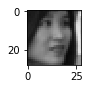

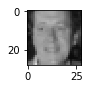

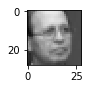

In [5]:
#Display images from our data 
def display_images(data,indices): 
    
    #Obtain the images inside data 
    im_data = data.train.images
    
    for i in range(len(indices)):
        
        #Set image sizing
        %matplotlib inline
        plt.figure(figsize=(1,1))
        
        #Unnormalize the image and reshape it
        im = Image.fromarray(np.multiply(im_data[indices[i]],255.0).reshape(28,28))
        
        #Show the image 
        p = plt.imshow(im)
        plt.show(p)

display_images(data,[4,45,599])

<h4>Deep Convolutional Generative Adversarial Networks:</h4>
<p>In 2016 Alec Radford, Luke Metz, and Soumith Chintala published <a href="https://arxiv.org/pdf/1511.06434.pdf">Unsupervised Representation Learning With Deep Convolutional
Generative Adversarial Networks</a>. In computer vision tasks, convolutional networks and supervised learning has had great success and popularity. However, unsupervised learning with convolutional neural networks has recieved less attention. Deep Convolutional Generative Adversarial Networks (DCGANs) demonstrate that they are a strong candidate for unsupervised learning. The generator/discriminator pair learns a hierarchy of representations from object parts to scenes in both the generator and discriminator. Since we are working with facial image data, implementing a DCGAN is a great choice. The architecture from the paper is as follows:</p>
<ul>
<li>Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator)</li>
<li>Use batchnorm in both the generator and the discriminator</li>
<li>Remove fully connected hidden layers for deeper architectures</li>
<li>Use ReLU activation in generator for all layers except for the output, which uses Tanh</li>
<li>Use LeakyReLU activation in the discriminator for all layers</li>
</ul>
<p>To build our DCGAN, we will use TensorFlow-Slim. This will allow us to build a complex network while keeping the model's architecure transparent.</p>

<h4>LeakyReLU layer:</h4>
<p>When we use GANs we want to avoid sparse gradients to prevent suffering in terms of GAN stability. This means we should stear clear from ReLU and MaxPool. Instead we can use a LeakyReLU layer. Let us create a leaky rectified linear unit layer that we will call in our discriminator as noted in the DCGAN architecture above. We build it as follows:</p>

In [6]:
#Create a LeakyReLU
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

<h4>Generator:</h4>
<p>Let us now use tensorflow and create our generator network. Our architecture will take form similar to the following:</p>
<img src="gen.png" style="width: 600px; height:300px">
<p>Above we see that we have our z input (uniformly distributed random numbers). We will create four deconvolutional layers. Each layer will have batch normalization. The first three layers will use the rectified linear unit (RELU) activation function, while the fourth deconvolutional layer will use the tanh activation function as specified in the paper. We will then output an image G(z). Our architecure for the generator will look as follows:</p>
<ul>
<li>Fully Connected Layer</li>
<li>Reshape</li>
<li>Deconvolutional Layer 1 - batch normalization, relu activation</li>
<li>Deconvolutional Layer 2 - batch normalization, relu activation</li>
<li>Deconvolutional Layer 3 - batch normalization, relu activation</li>
<li>Deconvolutional Layer 4 - batch normalization, tanh activation</li>
</ul>
<p>All in all, our generator will take in a vector consisting of random numbers from a uniform distribution, pass through four fractionally-strided convolutions (called deconvolutions), and then output an image with shape 32 x 32. We construct these layers in our generator as follows:</p>

In [7]:
def generator(z_shp):
    
    #Commonly Used Variables
    PADDING = "SAME"
    STRIDE = [2,2]
    
    #Our first dense (fully connected) layer
    g1_dense = slim.fully_connected(z_shp,4*4*256,normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g1_dense',weights_initializer=initializer)
    
    #Reshape
    g1_dense_reshape = tf.reshape(g1_dense,[-1,4,4,256])
    
    #Dconv Layer 1, batch normalization, relu activation
    g2_dconv = slim.convolution2d_transpose(\
        g1_dense_reshape,num_outputs=64,kernel_size=[5,5],stride=STRIDE,\
        padding=PADDING,normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g2_dconv', weights_initializer=initializer)
    
    #Dconv Layer 2, batch normalization, relu activation
    g3_dconv = slim.convolution2d_transpose(\
        g2_dconv,num_outputs=32,kernel_size=[5,5],stride=STRIDE,\
        padding=PADDING,normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g3_dconv', weights_initializer=initializer)
    
    #Dconv Layer 3, batch normalization, relu activation
    g4_dconv = slim.convolution2d_transpose(\
        g3_dconv,num_outputs=16,kernel_size=[5,5],stride=STRIDE,\
        padding=PADDING,normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g4_dconv', weights_initializer=initializer)
    
    #Dconv Layer 4, batch normalization, tanh activation
    g5_dconv = slim.convolution2d_transpose(\
        g4_dconv,num_outputs=1,kernel_size=[32,32],padding=PADDING,\
        biases_initializer=None,activation_fn=tf.nn.tanh,\
        scope='g5_dconv', weights_initializer=initializer)
    
    return g5_dconv

<p>We have now created our generator. Let us move on to creating our discriminator.</p>

<h4>Discriminator:</h4>
<p>Now that we have a generator to generate synthetic images we need to build our discriminator. Our discriminator model will have the following architecture:</p>
<img src="disc.png" style="width: 600px; height:300px">
<p>Our discriminator will have the following architecture:</p>
<ul>
<li>Convolutional Layer 1 - leaky relu activation</li>
<li>Convolutional Layer 2 - leaky relu activation</li>
<li>Convolutional Layer 3 - leaky relu activation</li>
<li>Fully Connected Layer  - Sigmoid activation</li>
</ul>
<p>Here we will input a 32 x 32 image and pass it through a few convolutional layers. It will then output a single valued probability representing whether the image is a "real" image or a "fake" image. We create the discriminator as follows:</p>

In [8]:
def discriminator(bottom, reuse=False):
    PADDING = "SAME"
    STRIDE = [2,2]
    
    #Conv Layer 1, No batch normalization, leaky relu activation
    d1_conv = slim.convolution2d(bottom,16,[4,4],stride=STRIDE,padding=PADDING,\
        biases_initializer=None,activation_fn=lrelu,\
        reuse=reuse,scope='d1_conv',weights_initializer=initializer)
    
    #Conv Layer 2, batch normalization, leaky relu activation
    d2_conv = slim.convolution2d(d1_conv,32,[4,4],stride=STRIDE,padding=PADDING,\
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
        reuse=reuse,scope='d2_conv', weights_initializer=initializer)
    
    #Conv Layer 3, batch normalization, leaky relu activation
    d3_conv = slim.convolution2d(d2_conv,64,[4,4],stride=STRIDE,padding=PADDING,\
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
        reuse=reuse,scope='d3_conv',weights_initializer=initializer)
    
    #Dense Layer (Fully connected), sigmoid activation
    d4_dense = slim.fully_connected(slim.flatten(d3_conv),1,activation_fn=tf.nn.sigmoid,\
        reuse=reuse,scope='d4_output', weights_initializer=initializer)
    
    return d4_dense

<h4>Model Creation:</h4>
<p>Now that we have our generator and discriminator we can now create our deep convolutional generative adversarial network (DCGAN). We will create a variable called z_size which will be the size of the z vector used for our generator. We will initialize all weights for our network. We do so here because we want to initialize the same weights. If we pass this into each weights_initializer parameter in our tf.slim code above we might be assigned different weights. We then create input for the generator and discriminator, and create the images for the random vectors and probabilites for the real images. We can then create the optimization objective and then apply gradient descent.   </p>

In [11]:
tf.reset_default_graph()

z_size = 100

#Initialize Network weights 
initializer = tf.truncated_normal_initializer(stddev=0.02)

#Input for Generator 
z_in = tf.placeholder(shape=[None,z_size],dtype=tf.float32) 

#Input for Discriminator
real_in = tf.placeholder(shape=[None,32,32,1],dtype=tf.float32)

#Creating Images for ranom vectors of size z_in
Gz = generator(z_in)

#Probabilities for real images
Dx = discriminator(real_in)

#Probabilities for generator images
Dg = discriminator(Gz,reuse=True)

#Optimize the discriminator and the generator
d_log1 = tf.log(Dx)
d_log2 = tf.log(1.-Dg)
g_log = tf.log(Dg)
d_loss = -tf.reduce_mean(d_log1 + d_log2) 
g_loss = -tf.reduce_mean(g_log) 

tvars = tf.trainable_variables()

#Use the Adam Optimizers for discriminator and generator 
LR = 0.0002
BTA = 0.5
trainerD = tf.train.AdamOptimizer(learning_rate=LR,beta1=BTA)
trainerG = tf.train.AdamOptimizer(learning_rate=LR,beta1=BTA)

#Gradients for discriminator and generator
gradients_discriminator = trainerD.compute_gradients(d_loss,tvars[9:]) 
gradients_generator = trainerG.compute_gradients(g_loss,tvars[0:9]) 

#Apply the gradients
update_D = trainerD.apply_gradients(gradients_discriminator)
update_G = trainerG.apply_gradients(gradients_generator)

<h4>Save Generated Images:</h4>
<p>Our GAN will create synthetic images during training. Let us now write a function to save our generated images. Here we will take in a vector of images, a size, and a path to save them. This will return us a block of images (6 x 6) so we can see how our model improves over time.We do so as follows:</p>

In [12]:
def save_generated_images(images,size,image_path): 
    images = (images+1.)/2.
    height = images.shape[1]
    width = images.shape[2]
    img = np.zeros((height * size[0], width * size[1]))
    for idx, image in enumerate(images):
        a = idx % size[1]
        b = idx // size[1]
        img[b*height:b*height+height, a*width:a*width+width] = image
    sve = scipy.misc.imsave(image_path,img)
    return sve

<h4>Network Training:</h4>
<p>Let us now train our network on our machine, a retina macbook pro with 8gb of ram. Since we are not using a GPU right now (we will do so in the next section), we will use 5000 iterations and a batch_size of 128. Here, we will choose a sample batch from our facial image data and shape it into a 32 x 32 image. We will then generate a random batch, z, and update the generator and discriminator. Every 15 iterations we will calculate our loss for both the generator and discriminator and plot them on an updating plot. We will also save some sample generated images from the generator at this stage. Every 1000 iterations we will save our model. We train our model as follows:</p>

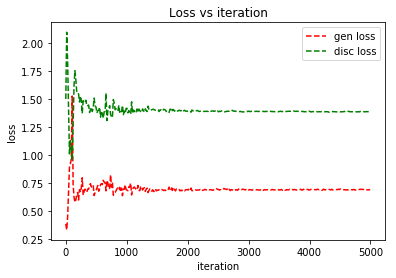

Progress:  4996 / 5000
Progress:  4997 / 5000
Progress:  4998 / 5000
Progress:  4999 / 5000


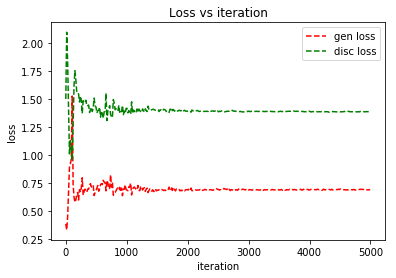

In [15]:
#size setups
batch_size = 128
iterations = 5000 

#tf setup
init = tf.global_variables_initializer()
saver = tf.train.Saver()

#plot setup
plt_g = np.array([])
plt_d = np.array([])
plt_x = np.array([])

with tf.Session() as sess:  
    sess.run(init)
    for i in range(iterations):
        print("Progress: ",i,"/",iterations)
    
        #Choose sample batch from data 
        xs,xt = data.train.batch_next(batch_size)
        
        #Make sure our data is between (-1,1)
        xs = np.lib.pad(((np.reshape(xs,[batch_size,28,28,1]) - 0.5) * 2.0),((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1))
        
        #Updating Discriminator Once and Generator Twice
        random_z_batch = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate a random z batch
        _,dLoss = sess.run([update_D,d_loss],feed_dict={z_in:random_z_batch,real_in:xs}) 
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:random_z_batch}) 
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:random_z_batch})
        

        #Training Stats
        if i % 15 == 0:
            #Plot our generator loss and discriminator loss
            print("Gen Loss: " + str(gLoss) + " Disc Loss: " + str(dLoss))
            plt_g = np.append(plt_g,float(gLoss))
            plt_d = np.append(plt_d,float(dLoss))
            plt_x = np.append(plt_x,i)
            plt.gca().cla() 
            plt.plot(plt_x,plt_g,'r--',label='gen loss')
            plt.plot(plt_x,plt_d,'g--',label='disc loss')
            plt.xlabel('iteration')
            plt.ylabel('loss')
            plt.title('Loss vs iteration')
            plt.legend()
            display.clear_output(wait=True)
            display.display(plt.gcf())       
            
            #Get sample images from the generator
            z2 = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) 
            newZ = sess.run(Gz,feed_dict={z_in:z2})
            
            #Save our generated images 
            if not os.path.exists('./facial_figs'):
                os.makedirs('./facial_figs')
            save_generated_images(np.reshape(newZ[0:36],[36,32,32]),[6,6],'./facial_figs/fig'+str(i)+'.png')
        
        #Save our model every 1000 iterations
        if i % 1000 == 0 and i != 0:
            if not os.path.exists('./facial_models'):
                os.makedirs('./facial_models')
            saver.save(sess,'./facial_models/model-'+str(i)+'.cptk')
            print("Saved Model")

<h4>Generating New Images:</h4>
<p>Now, we have a trained model. We can now generate new images from this trained model. We can load our saved model from the previous step and draw a set set of uniformly randomly distributed numbers that is size 36 x 128 (128 is our previous batch size). We can then use this new z to generate sample images from the generator. We will then save the newly generated images into a directory called synthetic_faces.</p>

In [16]:
batch_size_sample = 36
num_img = 10
init = tf.initialize_all_variables()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    
    #Load previos Model and weights
    ckpt = tf.train.get_checkpoint_state('./facial_models')
    saver.restore(sess,ckpt.model_checkpoint_path)
    
    #Generate 10 synthetic facial iamges 
    for k in range(num_img):
        #Generate random uniform to generate synthetic images
        rand_z = np.random.uniform(-1.0,1.0,size=[batch_size_sample,z_size]).astype(np.float32) 
        newZ = sess.run(Gz,feed_dict={z_in:rand_z}) 
    
        #Save synthetic image
        if not os.path.exists('./synthetic_faces'):
            os.makedirs('./synthetic_faces')
        save_generated_images(np.reshape(newZ[0:batch_size_sample],[36,32,32]),[6,6],'synthetic_faces/synthetic_face'+str(k)+'.png')

Instructions for updating:
Use `tf.global_variables_initializer` instead.


<p>Let us now take a look at some of the syntetic facial images we have created:</p>

<img src="synthetic_faces/synthetic_face9.png" style="width:200px; height:200px">
<br>
<img src="synthetic_faces/synthetic_face8.png" style="width:200px; height:200px">

<p>Above we see that with just 5000 iterations we have generated synthetic facial images. Let us look at a timelapse of our training process. To create this timelaps, I have taken all training images and uploaded them to makeagif.com. You can find the generated gif <a href="http://makeagif.com/gif/ajl-gan-training-lfw-2e1eDG">here</a> as well as below:</p>
<img src="AJL_GAN_training_LFW.gif">

<p>We see that as we started training the generated images looked like random lines and dots. However, the generator became more and more successful as the images look more and more like faces as time progresses.</p>

<h4>Using a GPU for training:</h4>
<p>We see that we had good success with training on only 5,000 iterations on our CPU. The training process took just over 8 hours. Let us now run 50,000 iterations and see how our performance improves. This training process is very computationally expensive so we will utilize Amazon Web Services p2.8xlarge machine for training our model. This machine has 8 GPUs, 32 vCPU, 488 GiB of memory, 19968 parallel processing cores, 96 GiB of GPU memory, and 10 Gigabit network performance. This is a very powerful machine and at the cost of a few dollars an hour we should be able to train our model in no time.</p>
<p>However, we need to alter our code slightly to enable GPU support. We make the changes as follows by enabling GPU support and running the following code:</p>

In [ ]:
DEVICE='/gpu:0'
with tf.device(DEVICE):
    tf.reset_default_graph()

    z_size = 100

    #Initialize Network weights 
    initializer = tf.truncated_normal_initializer(stddev=0.02)

    #Input for Generator 
    z_in = tf.placeholder(shape=[None,z_size],dtype=tf.float32) 

    #Input for Discriminator
    real_in = tf.placeholder(shape=[None,32,32,1],dtype=tf.float32)

    #Creating Images for ranom vectors of size z_in
    Gz = generator(z_in)

    #Probabilities for real images
    Dx = discriminator(real_in)

    #Probabilities for generator images
    Dg = discriminator(Gz,reuse=True)

    #Optimize the discriminator and the generator
    d_log1 = tf.log(Dx)
    d_log2 = tf.log(1.-Dg)
    g_log = tf.log(Dg)
    d_loss = -tf.reduce_mean(d_log1 + d_log2) 
    g_loss = -tf.reduce_mean(g_log) 

    tvars = tf.trainable_variables()

    #Use the Adam Optimizers for discriminator and generator 
    LR = 0.0002
    BTA = 0.5
    trainerD = tf.train.AdamOptimizer(learning_rate=LR,beta1=BTA)
    trainerG = tf.train.AdamOptimizer(learning_rate=LR,beta1=BTA)

    #Gradients for discriminator and generator
    gradients_discriminator = trainerD.compute_gradients(d_loss,tvars[9:]) 
    gradients_generator = trainerG.compute_gradients(g_loss,tvars[0:9]) 

    #Apply the gradients
    update_D = trainerD.apply_gradients(gradients_discriminator)
    update_G = trainerG.apply_gradients(gradients_generator)

<p>We can now apply our previous training code to start training the model on the AWS instance:</p>

In [ ]:
#size setups
batch_size = 128
iterations = 50000 

#tf setup
init = tf.global_variables_initializer()
saver = tf.train.Saver()

#plot setup
plt_g = np.array([])
plt_d = np.array([])
plt_x = np.array([])

with tf.Session() as sess:  
    sess.run(init)
    for i in range(iterations):
        print("Progress: ",i,"/",iterations)
    
        #Choose sample batch from data 
        xs,xt = data.train.batch_next(batch_size)
        
        #Make sure our data is between (-1,1)
        xs = np.lib.pad(((np.reshape(xs,[batch_size,28,28,1]) - 0.5) * 2.0),((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1))
        
        #Updating Discriminator Once and Generator Twice
        random_z_batch = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate a random z batch
        _,dLoss = sess.run([update_D,d_loss],feed_dict={z_in:random_z_batch,real_in:xs}) 
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:random_z_batch}) 
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:random_z_batch})
        

        #Training Stats
        if i % 15 == 0:
            #Plot our generator loss and discriminator loss
            print("Gen Loss: " + str(gLoss) + " Disc Loss: " + str(dLoss))
            plt_g = np.append(plt_g,float(gLoss))
            plt_d = np.append(plt_d,float(dLoss))
            plt_x = np.append(plt_x,i)
            plt.gca().cla() 
            plt.plot(plt_x,plt_g,'r--',label='gen loss')
            plt.plot(plt_x,plt_d,'g--',label='disc loss')
            plt.xlabel('iteration')
            plt.ylabel('loss')
            plt.title('Loss vs iteration')
            plt.legend()
            display.clear_output(wait=True)
            display.display(plt.gcf())       
            
            #Get sample images from the generator
            z2 = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) 
            newZ = sess.run(Gz,feed_dict={z_in:z2})
            
            #Save our generated images 
            if not os.path.exists('./gpu_facial_figs'):
                os.makedirs('./gpu_facial_figs')
            save_generated_images(np.reshape(newZ[0:36],[36,32,32]),[6,6],'./gpu_facial_figs/fig'+str(i)+'.png')
        
        #Save our model every 1000 iterations
        if i % 1000 == 0 and i != 0:
            if not os.path.exists('./gpu_facial_models'):
                os.makedirs('./gpu_facial_models')
            saver.save(sess,'./gpu_facial_models/model-'+str(i)+'.cptk')
            print("Saved Model")

<p>A small sample of the training from our DCGAN on the GPU is as follows:</p>

<img src="gpu_1.png" style="width:200px; height:200px">
<img src="gpu_2.png" style="width:200px; height:200px">

<p>We see that the images are now much more detailed with 50,000 iterations.</p>

<p>All in all, we have used a deep convolutional generative adversarial network to create synthetic facial images. We have seen that using the GPU with 50,000 iterations resulted in synthetic facial images that looked more realistic than our CPU with 5,000 iterations.</p>